In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [13]:
# with open("./output_files/couples_new.json") as json_file:
#     couples = json.load(json_file)

# with open("./output_files/compare/Melan.A/che_phy.json") as json_file:
#     couples_by_che = json.load(json_file)

with open("couples_test.json") as json_file:
    couples = json.load(json_file)

with open("./output_files/tests/cdr3/test_full.json") as json_file:
    couples = json.load(json_file)

# couples = couples_by_che

In [14]:
max_neig = 1
# Create a graph
G = nx.Graph()

# Add edges to the graph based on the dictionary
for node, neighbors in couples.items():
    count = 0
    for neighbor, weight in neighbors:
        if count < max_neig:
            G.add_edge(node, neighbor, weight=weight)
            count += 1

In [15]:
from pyvis.network import Network


# Create Network object
net = Network(notebook=True)

# Load networkx graph into pyvis
net.from_nx(G)

# Enable options for better visualization
net.show_buttons(filter_=['physics'])

# Save and display
# net.show('graph.html')
net.save_graph('output_files/chephy_weighted.html')

In [4]:
def get_edges_colors(G):
    # color edegs according to their connection, the greener the color the stringer the connection
    # Create a colormap ranging from red to green
    cmap = plt.cm.RdYlGn_r

    # Find the maximum and minimum weights
    max_weight = max([d['weight'] for _, _, d in G.edges(data=True)])
    min_weight = min([d['weight'] for _, _, d in G.edges(data=True)])

    # Normalize the weights
    norm = mcolors.Normalize(vmin=min_weight, vmax=max_weight)

    # Create a color mapping based on edge weights
    edge_colors = [cmap(norm(d['weight'])) for _, _, d in G.edges(data=True)]
    return edge_colors
    

### Visualize the whole graph

### Highest degree node

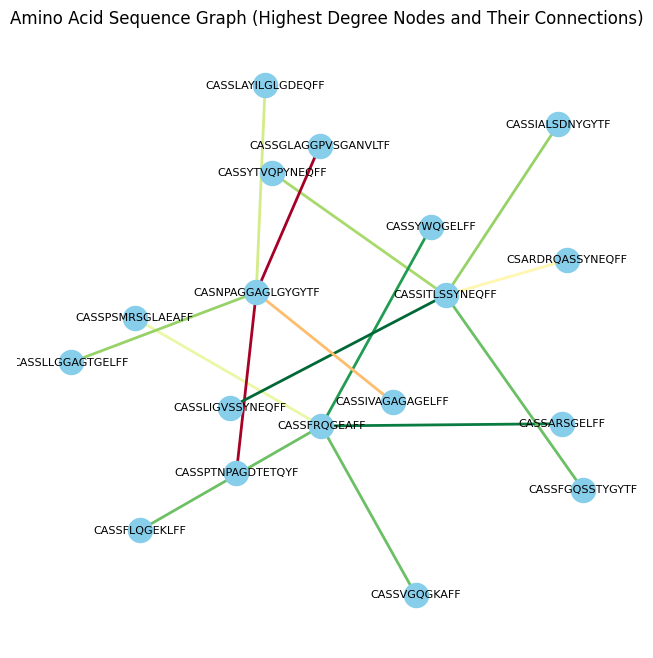

In [5]:
max_degree = max(dict(G.degree()).values())
highest_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree == max_degree]

# Create a subgraph with only the highest degree nodes and their neighbors
highest_degree_neighbors = set()
for node in highest_degree_nodes:
    highest_degree_neighbors.update(G.neighbors(node))
highest_degree_neighbors.update(highest_degree_nodes)
H = G.subgraph(highest_degree_neighbors)

edge_colors = get_edges_colors(H)

# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)

# # Draw edge labels with three numbers after the decimal point
# edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in H.edges(data=True)}
# nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='black')

plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
plt.axis('off')  # Turn off axis
plt.savefig('degree.png')
plt.show()


### Longest path

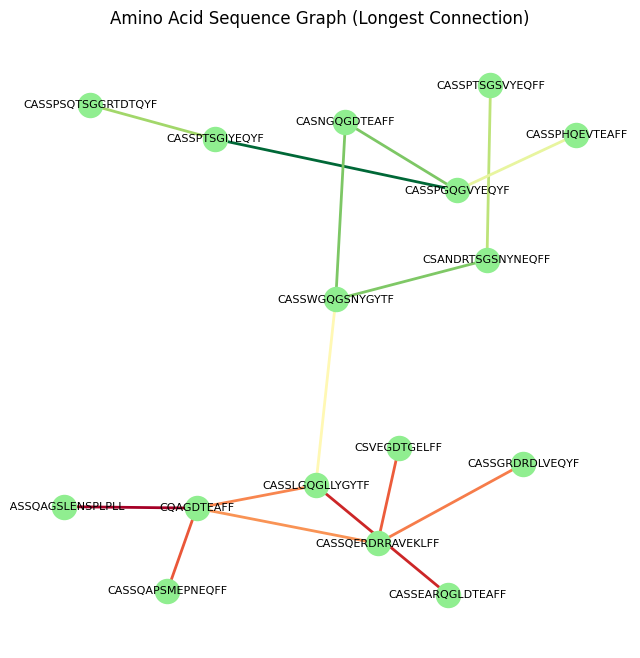

In [9]:
# Find the longest path in the graph
longest_path = max(nx.all_pairs_shortest_path_length(G), key=lambda x: max(x[1].values()))

# Extract nodes involved in the longest path
longest_path_nodes = longest_path[1].keys()

# Create a subgraph with nodes involved in the longest path
H = G.subgraph(longest_path_nodes)

edge_colors = get_edges_colors(H)


# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=1, iterations=100)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)

# # Draw edge labels with three numbers after the decimal point
# edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in H.edges(data=True)}
# nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='black')


plt.title('Amino Acid Sequence Graph (Longest Connection)')
plt.axis('off')  # Turn off axis
plt.savefig('longest_path.png')
plt.show()

### Strongest Connection

### Biggest Cluster

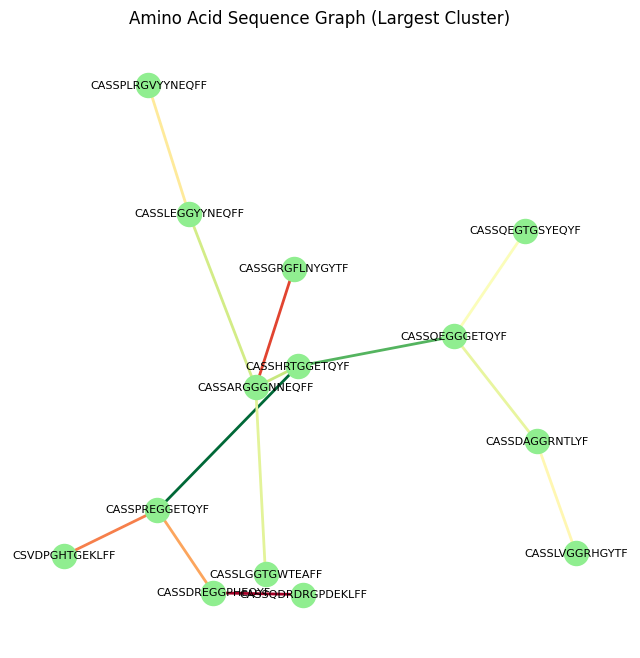

In [46]:

# Find all connected components
connected_components = list(nx.connected_components(G))

# Find the largest connected component
largest_component = max(connected_components, key=len)

# Find nth largest connected component
n = 2
largest_component = sorted(nx.connected_components(G), key=len, reverse=True)[n-1]



# Create a subgraph with nodes in the largest connected component
H = G.subgraph(largest_component)

edge_colors = get_edges_colors(H)

# Visualize the largest cluster
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)


plt.title('Amino Acid Sequence Graph (Largest Cluster)')
plt.axis('off')  # Turn off axis
plt.savefig('largest_cluster.png')
plt.show()


In [47]:
import pandas as pd

df = pd.read_csv("output_files/tests/cdr3/predicted clusters.csv")
df = df.dropna(subset=['epitope.pred'])
true_labels = df['antigen.epitope']
predicted_labels = df["epitope.pred"]


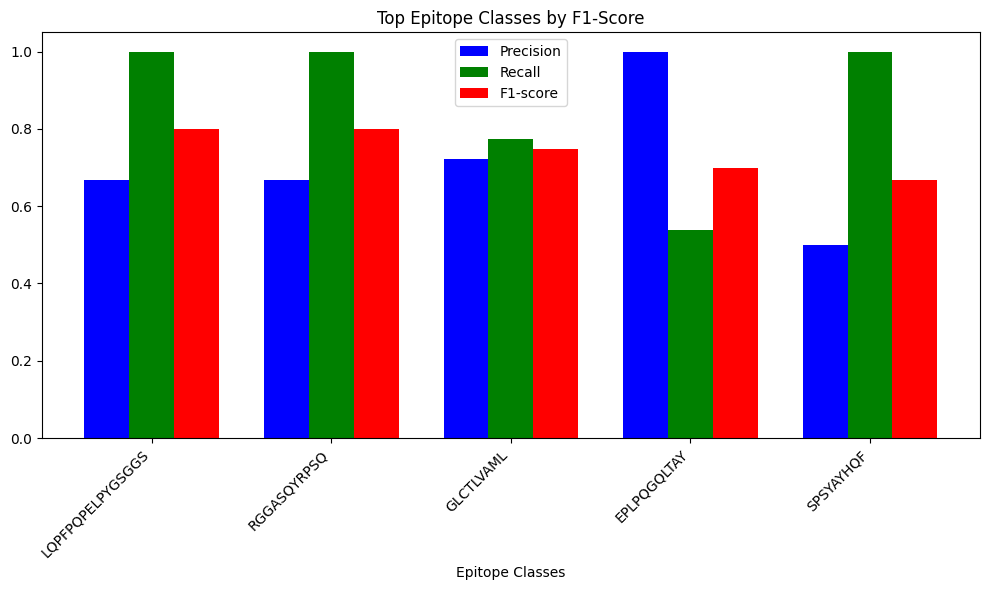

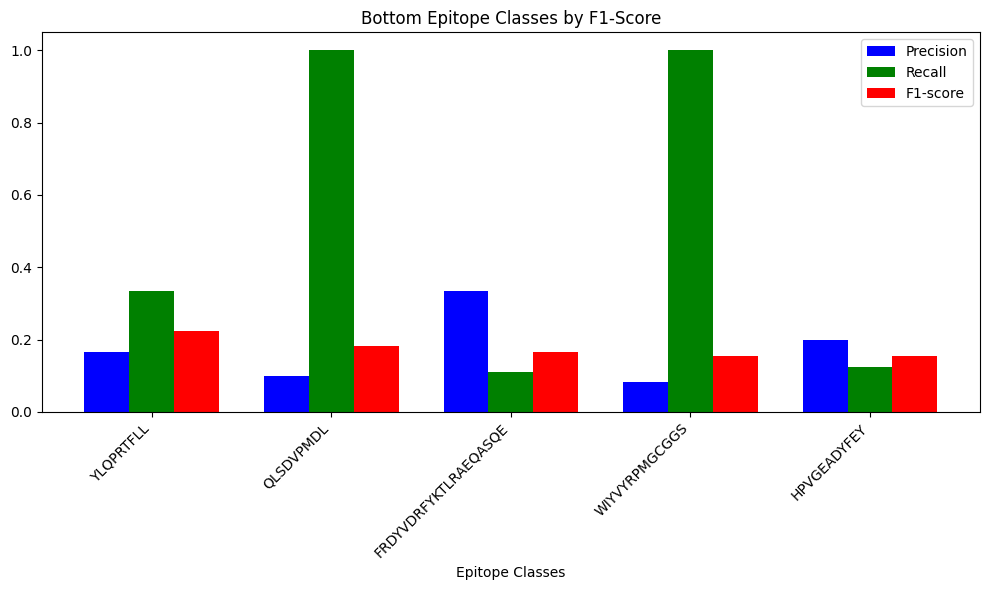

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming your DataFrame is named 'df' with columns 'antigen.epitope' and 'epitope.pred'
true_labels = df['antigen.epitope']
predicted_labels = df['epitope.pred']

# Generate the classification report as a dictionary
report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0)

# Extract the precision, recall, and F1-score for each epitope class
classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score = [report[cls]['f1-score'] for cls in classes]

# Filter out classes where precision, recall, and F1-score are all 0
filtered_classes = []
filtered_metrics = []

for i, cls in enumerate(classes):
    if not (precision[i] == 0 and recall[i] == 0 and f1_score[i] == 0):
        filtered_classes.append(cls)
        filtered_metrics.append([precision[i], recall[i], f1_score[i]])

# Convert to numpy array for easier manipulation
metrics_data = np.array(filtered_metrics)

# Sort by F1-score in descending order
sorted_indices = np.argsort(metrics_data[:, 2])[::-1]  # Sort by F1-score (column 2) in descending order
sorted_classes = np.array(filtered_classes)[sorted_indices]
sorted_metrics = metrics_data[sorted_indices]

# Select the top and bottom N classes based on F1-score
N = 5  # You can change this number to select more or fewer classes
top_classes = sorted_classes[:N]
top_metrics = sorted_metrics[:N]

bottom_classes = sorted_classes[-N:]
bottom_metrics = sorted_metrics[-N:]

# Function to plot a bar chart for the top/bottom classes
def plot_metrics(classes, metrics, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.25
    index = np.arange(len(classes))

    # Plot each metric with an offset for clarity
    ax.bar(index, metrics[:, 0], bar_width, label='Precision', color='b')
    ax.bar(index + bar_width, metrics[:, 1], bar_width, label='Recall', color='g')
    ax.bar(index + 2 * bar_width, metrics[:, 2], bar_width, label='F1-score', color='r')

    # Set up the plot labels and title
    ax.set_xlabel('Epitope Classes')
    ax.set_title(title)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot top F1-score epitopes
plot_metrics(top_classes, top_metrics, 'Top Epitope Classes by F1-Score')

# Plot bottom F1-score epitopes
plot_metrics(bottom_classes, bottom_metrics, 'Bottom Epitope Classes by F1-Score')


In [49]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = pd.read_csv("output_files/tests/cdr3/predicted clusters.csv")


# Ensure that the columns are converted to strings
df['antigen.epitope'] = df['antigen.epitope'].astype(str)
df['epitope.pred'] = df['epitope.pred'].astype(str)

# Calculate accuracy
accuracy = accuracy_score(df['antigen.epitope'], df['epitope.pred'])

# Calculate precision
precision = precision_score(df['antigen.epitope'], df['epitope.pred'], average='weighted', zero_division=0)

# Calculate recall
recall = recall_score(df['antigen.epitope'], df['epitope.pred'], average='weighted', zero_division=0)

f1 = f1_score(df['antigen.epitope'], df['epitope.pred'], average='weighted', zero_division=0)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1_score: {f1}')


Accuracy: 0.4168994413407821
Precision: 0.34983426830538084
Recall: 0.4168994413407821
f1_score: 0.36922116420715756


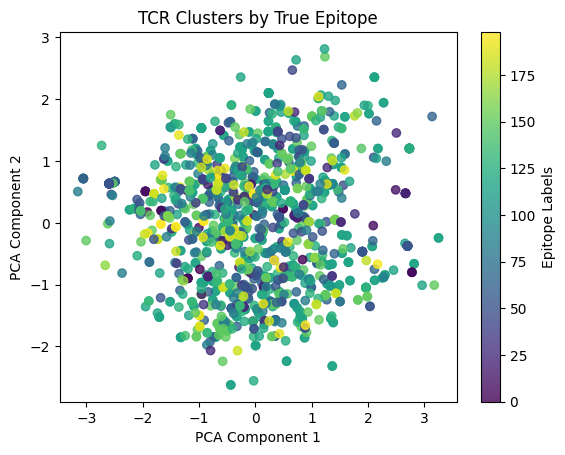

In [50]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# Assuming your DataFrame is named 'df' with 'tcr' and 'antigen.epitope' columns
tcr_sequences = df['cdr3']
true_labels = df['antigen.epitope']

# Step 1: Encode the TCR sequences (assuming amino acid sequences, using count-based encoding as an example)
vectorizer = CountVectorizer(analyzer='char')  # Analyzing at the character level
tcr_encoded = vectorizer.fit_transform(tcr_sequences).toarray()

# Step 2: Perform PCA
pca = PCA(n_components=2)
transformed = pca.fit_transform(tcr_encoded)

# Step 3: Encode the true epitope labels into numeric values for color mapping
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(true_labels)

# Step 4: Create the scatter plot
plt.scatter(transformed[:, 0], transformed[:, 1], c=encoded_labels, cmap='viridis', alpha=0.8)
plt.title('TCR Clusters by True Epitope')
plt.colorbar(label='Epitope Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()
